---
title: "Intro to NNs: MNIST"
description: "Introduction to Neural Networks with MNIST dataset"
date: 2025-07-17
date-modified: last-modified
author:
  - id: sf
    name: Sam Foreman
    orcid: 0000-0002-9981-0876
    email: foremans@anl.gov
    affiliation:
      - name: '[ANL](https://www.anl.gov/)'
        city: Lemont
        state: IL
        url: https://alcf.anl.gov/about/people/sam-foreman
  - id: mn
    name: Marieme Ngom
    # orcid: 0000-0002-9981-0876
    email: mngom@anl.gov
    affiliation:
      - name: '[ANL](https://www.anl.gov/)'
        city: Lemont
        state: IL
        url: https://alcf.anl.gov/about/people/marieme-ngom
  - id: hz
    name: Huihuo Zheng
    # orcid: 0000-0002-9981-0876
    email: huihuo.zheng@anl.gov
    affiliation:
      - name: '[ANL](https://www.anl.gov/)'
        city: Lemont
        state: IL
        url: https://alcf.anl.gov/about/people/huihuo-zheng
  - id: bl
    name: Bethany Lusch
    email: blusch@anl.gov
    orcid: 0000-0002-9521-9990
    # orcid: 0000-0002-9981-0876
    affiliation:
      - name: '[ANL](https://www.anl.gov/)'
        city: Lemont
        state: IL
        url: https://alcf.anl.gov/about/people/bethany-lusch
  - id: tc
    name: Taylor Childers
    orcid: 0000-0002-0492-613X
    email: jchilders@anl.gov
    affiliation:
      - name: '[ANL](https://www.anl.gov/)'
        city: Lemont
        state: IL
        url: https://alcf.anl.gov/about/people/taylor-childers
---

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/saforem2/intro-hpc-bootcamp-2025/blob/main/docs/02-llms/1-hands-on-llms/index.ipynb)

::: {.callout-note}
Content for this tutorial has been modified from content originally written by:

Marieme Ngom, Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers,
Corey Adams, Kyle Felker, and Tanwi Mallick
:::

## Getting Started
This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset. 

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.

::: {#fig-mnist-task}

![](../images/mnist_task.png){width=400px}

MNIST sample
:::

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', 'svg', 'png')
import os
os.environ["TRUECOLOR"] = "1"
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 400

In [2]:
import ambivalent
import ezpz
import matplotlib.pyplot as plt
import seaborn as sns

# console = ezpz.log.get_console()
# logger = ezpz.get_logger('mnist')

plt.style.use(ambivalent.STYLES["ambivalent"])
sns.set_context("notebook")
plt.rcParams["figure.figsize"] = [6.4, 4.8]

[2025-08-04 23:22:01,582514][I][ezpz/__init__:265:ezpz] Setting logging level to 'INFO' on 'RANK == 0'

[2025-08-04 23:22:01,584493][I][ezpz/__init__:266:ezpz] Setting logging level to 'CRITICAL' on all others 'RANK != 0'

In [3]:
# %matplotlib inline

import time

import matplotlib.pyplot as plt
import numpy
import torch
import torchvision
from torch import nn

## The MNIST dataset

We will now download the dataset that contains handwritten digits.
MNIST is a popular dataset, so we can download it via the PyTorch library.

Note:

- `x` is for the inputs (images of handwritten digits)
- `y` is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets.
  - Training datasets are used to fit the model.
  - Test datasets are saved until the end, when we are satisfied with our
    model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.

The data is split as follows:

- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example 

In [4]:
training_data = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

In [5]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(
    training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55)
)

In [6]:
print(
    " ".join(
        [
            f"MNIST data loaded:",
            f"train={len(training_data)} examples",
            f"validation={len(validation_data)} examples",
            f"test={len(test_data)} examples",
            f"input shape={training_data[0][0].shape}",
        ]
    )
)
# print(f'Input shape', training_data[0][0].shape)

MNIST data loaded: train=48000 examples validation=12000 examples test=10000 examples input shape=torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

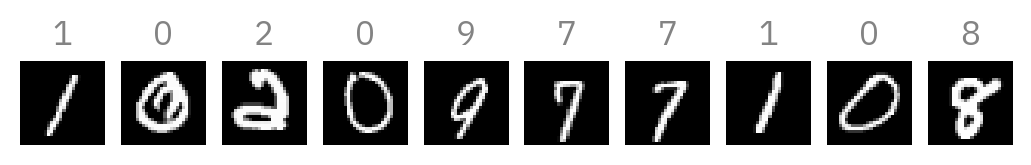

In [7]:
pltsize = 1
# plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis("off")
    # x, y = training_data[i]
    # plt.imshow(x.reshape(28, 28), cmap="gray")
    # x[0] is the image, x[1] is the label
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title(f"{training_data[i][1]}")

<Axes: >

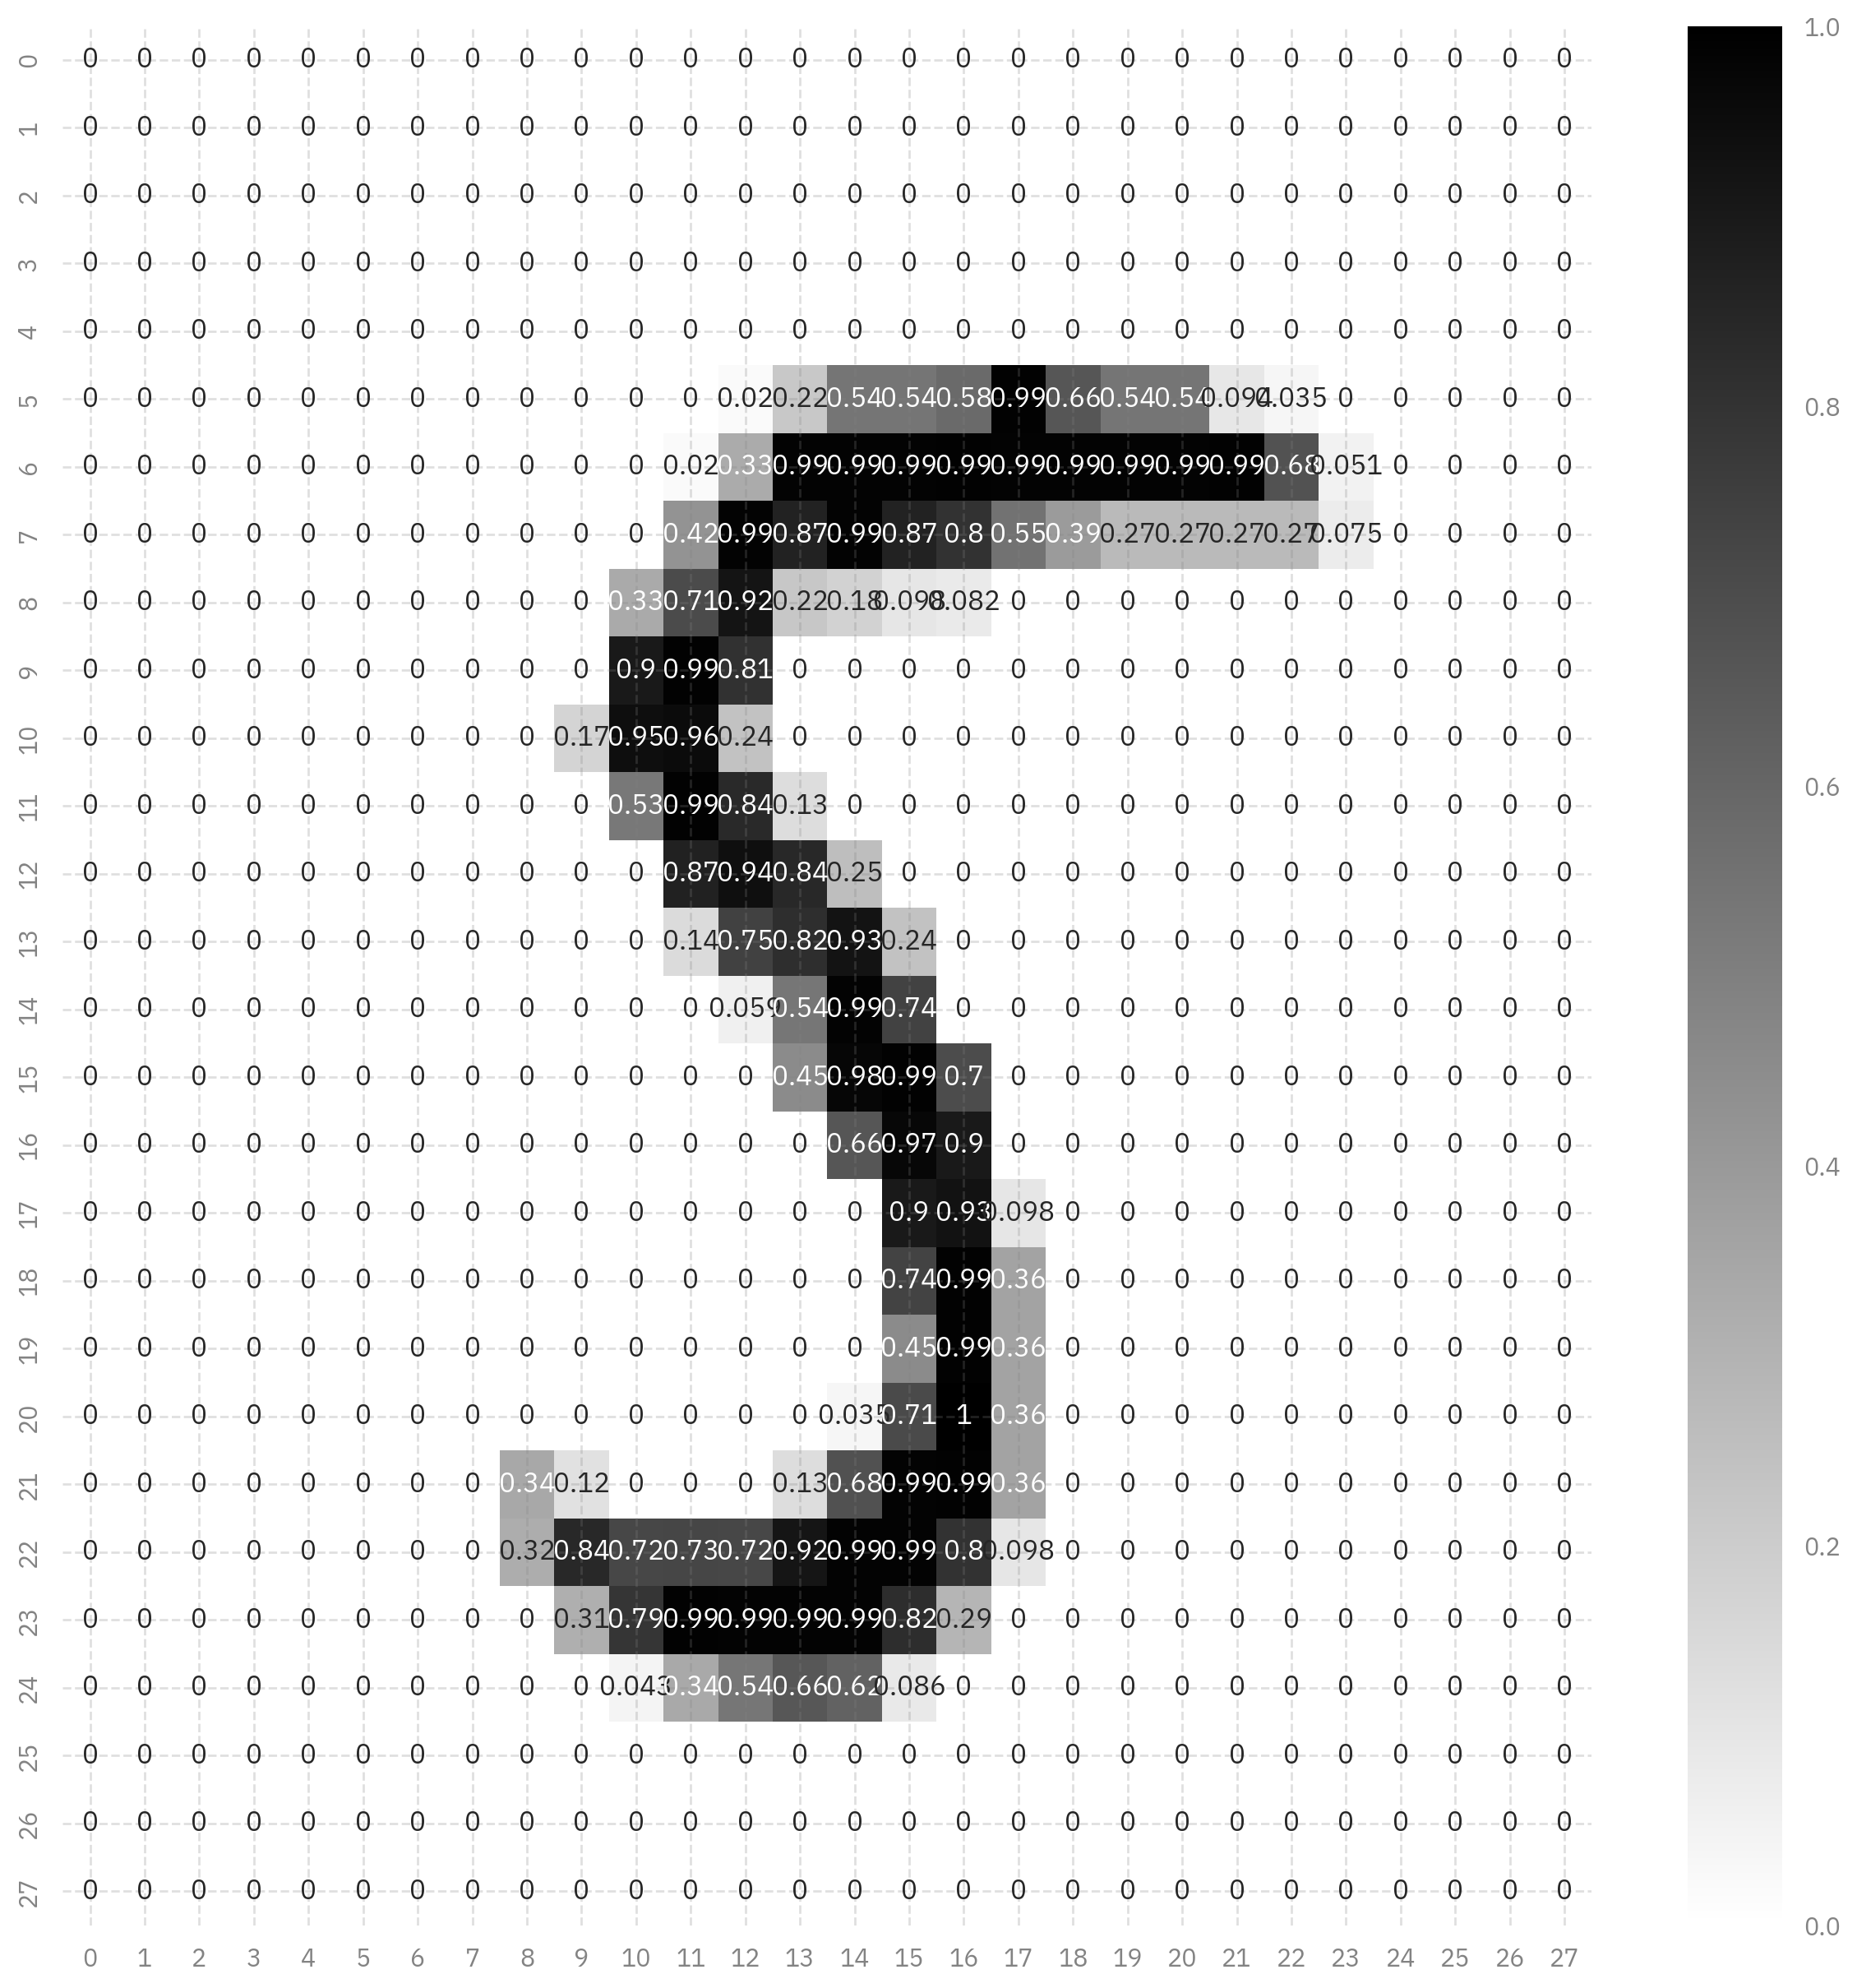

In [8]:
plt.figure(figsize=(15, 15))
sns.heatmap(training_data[30][0].reshape((28, 28)), annot=True, cmap="binary")

## Generalities:

To train our classifier, we need (besides the data):

- A model that depend on parameters $\mathbf{\theta}$.
  Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

## Linear Model

Let's begin with a simple linear model: linear regression, like last week. 

We add one complication: each example is a vector (flattened image), so the
"slope" multiplication becomes a dot product.
If the target output is a vector as well, then the multiplication becomes
matrix multiplication. 

Note, like before, we consider multiple examples at once, adding another
dimension to the input.

<!--
::: {#fig-linear-model}

![](../images/LinearModel_1.png)

Linear model for classification
:::
-->

::: {#fig-linear-svg}

![](../../assets/linear-net-with-weights.svg)

Fully connected linear net
:::

The linear layers in PyTorch perform a basic $xW + b$.

These "fully connected" layers connect each input to each output with some
weight parameter.

We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the
class label and minimizing mean squared error to work well - the model would
output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:

- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W
  and b).
  Last week, we used mean squared error (MSE), but this week let's make two
  changes that make more sense for classification:
  - Change the output to be a length-10 vector of class probabilities (0 to 1,
    adding to 1).
  - Cross entropy as the loss function, which is typical for classification.
    You can read more
    [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/).
- An optimization method or optimizer such as the stochastic gradient descent
  (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with
  stochastic gradient descent (sgd), like last week. For far more information
  about more advanced optimizers than basic SGD, with some cool animations, see
  <https://ruder.io/optimizing-gradient-descent/> or
  <https://distill.pub/2017/momentum/>.
- A learning rate.
  As we learned last week, the learning rate controls how far we move during
  each step. 

In [9]:
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()
        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        # (one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer_1(x)
        return x

In [10]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


## Learning

Now we are ready to train our first model.

A training step is comprised of:

- A forward pass: the input is passed through the network
- Backpropagation:
  A backward pass to compute the gradient
  $\frac{\partial J}{\partial \mathbf{W}}$ 
  of the loss function with respect to the parameters of the network.
- Weight updates
  $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}}$
  where $\alpha$ is the learning rate.

How many steps do we take?

- The batch size corresponds to the number of training examples in one pass
  (forward + backward).
  - A smaller batch size allows the model to learn from individual examples but
    takes longer to train.
  - A larger batch size requires fewer steps but may result in the model not
    capturing the nuances in the data.
- The higher the batch size, the more memory you will require.
- An epoch means one pass through the whole training data (looping over the
  batches).
  Using few epochs can lead to underfitting and using too many can lead
  to overfitting.
- The choice of batch size and learning rate are important for performance,
  generalization and accuracy in deep learning.


In [11]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [12]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        # backward pass calculates gradients
        loss.backward()
        # take one step with these gradients
        optimizer.step()
        # resets the gradients
        optimizer.zero_grad()

In [13]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100 * correct
    return accuracy, loss

In [14]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.5018792031606039, accuracy: 87.63333333333333
Epoch 0: val. loss: 0.49411888864446196, val. accuracy: 87.725
1: training loss: 0.4217252082824707, accuracy: 89.01875

Epoch 1: val. loss: 0.412469542089929, val. accuracy: 88.94166666666666
2: training loss: 0.38779040312767027, accuracy: 89.6875666666666

Epoch 2: val. loss: 0.37800481852064743, val. accuracy: 89.525666


3: training loss: 0.3678283305168152, accuracy: 90.11458333333333
Epoch 3: val. loss: 0.3578848899044889, val. accuracy: 89.9533333

4: training loss: 0.3542445518175761, accuracy: 90.43541666666667
Epoch 4: val. loss: 0.3443203260923954, val. accuracy: 90.28333333333333
CPU times: user 10.8 s, sys: 868 ms, total: 11.7 s
Wall time: 11.3 s


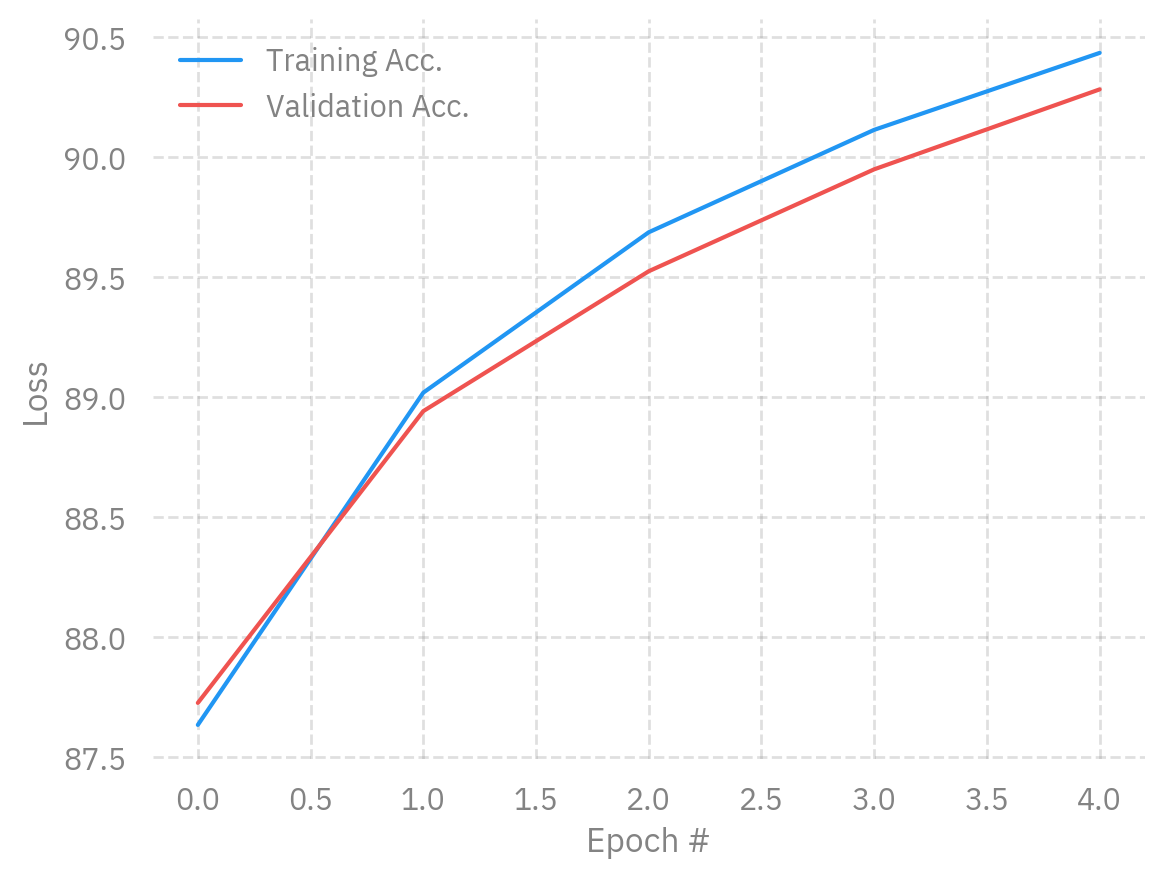

In [15]:
plt.figure()
plt.plot(range(epochs), train_acc_all, label="Training Acc.")
plt.plot(range(epochs), val_acc_all, label="Validation Acc.")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

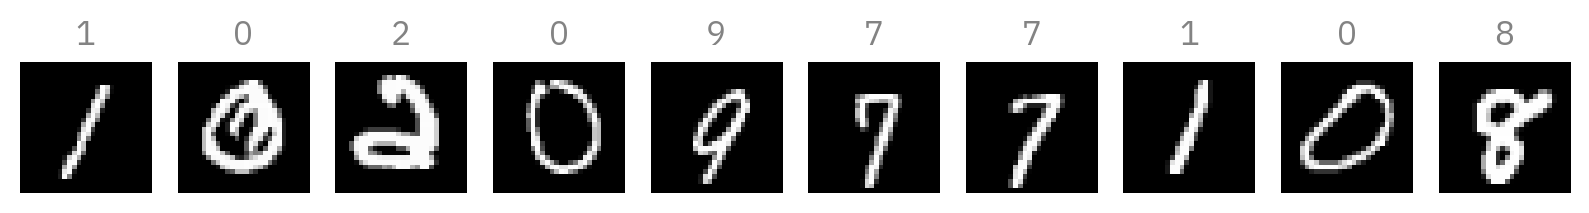

In [16]:
# Visualize how the model is doing on the first 10 examples
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis("off")
    plt.imshow(batch[0][i, 0, :, :], cmap="gray")
    plt.title("%d" % predictions[i, :].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc. 

## Prediction

Let's see how our model generalizes to the unseen test data.


In [17]:
# For HW: cell to change batch size
# create dataloader for test data
# The dataloader makes our dataset iterable

batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [18]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print(f"Test loss: {loss_test}, test accuracy: {acc_test}")
# print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.33246213272213937, test accuracy: 90.86999999999999


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [19]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded != batch[1]
    print(f"Showing max {maxtoshow} first failures.")
    print("The predicted class is shown first and the correct class in parentheses.")
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii >= maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii + 1)
            plt.axis("off")
            plt.imshow(batch[0][i, 0, :, :], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the test data that this small model classified to a wrong class:


Showing max 10 first failures.
The predicted class is shown first and the correct class in parentheses.


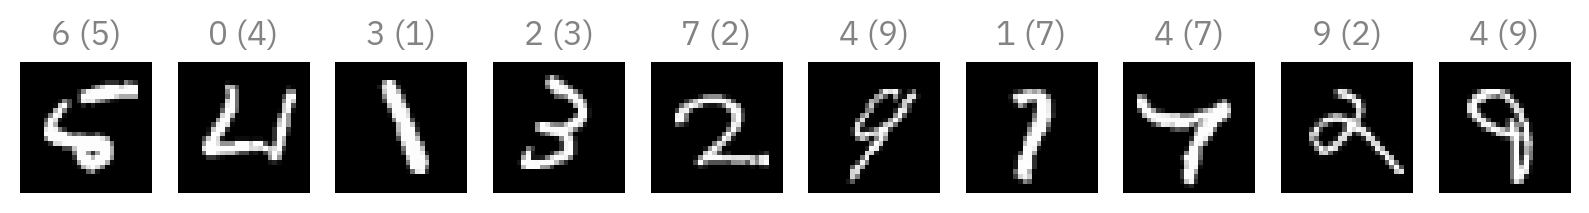

In [20]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

## Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.

::: {#fig-shallow-nn}

![](../images/shallow_nn.png)


Shallow neural network
:::

The output of this NN can be written as

$$
\begin{equation}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
$$

where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural
network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$
its biases.
The activation function introduces the nonlinearity and makes it
possible to learn more complex tasks.
Desirable properties in an activation
function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)

::: {#fig-activation}

![](../images/activation.jpeg)

Activation functions
:::


Adding more layers to obtain a deep neural network:

::: {#fig-nn-annotated}

![](../images/deep_nn_annotated.jpg)

:::


## Important things to know

Deep Neural networks can be overly flexible/complicated and "overfit" your
data, just like fitting overly complicated polynomials:


::: {#fig-bias-variance}

![](../images/bias_vs_variance.png)

Bias-variance tradeoff
:::


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):

::: {#fig-acc-under-over}
![](./images/acc_under_over.webp)

Visualization of accuracy and loss
:::



To improve the generalization of our model on previously unseen data, we employ
a technique known as regularization, which constrains our optimization problem
in order to discourage complex models.

  - Dropout is the commonly used regularization technique.
    The Dropout layer randomly sets input units to 0 with a frequency of rate
    at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as 
    $\lambda ||\mathbf{W}||^2$
    is alsp a commonly used regularization technique.
    This helps "control" the magnitude of the weights of the network.

Vanishing gradients
: Gradients become small as they propagate backward through the layers.
: Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients
: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch.

`nn.Dropout()` performs the Dropout operation mentioned earlier:

In [21]:
# For HW: cell to change activation
class NonlinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28 * 28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [22]:
#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [23]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.8711661319732666, accuracy: 75.1875
Epoch 0: val. loss: 0.8697689403878882, val. accuracy: 74.55833333333334
1: training loss: 0.4198738198677699, accuracy: 88.297916666666674

Epoch 1: val. loss: 0.4143052941307108, val. accuracy: 88.45833333333334
2: training loss: 0.3039622515439987, accuracy: 91.302083333333334

Epoch 2: val. loss: 0.2973113705186134, val. accuracy: 91.33333334


3: training loss: 0.2426262723406156, accuracy: 93.02291666666666
Epoch 3: val. loss: 0.23850328285009303, val. accuracy: 92.86666666666666
4: training loss: 0.19915112743775049, accuracy: 94.241666666666676

Epoch 4: val. loss: 0.1988548755328706, val. accuracy: 94.11666666666667
CPU times: user 11.7 s, sys: 833 ms, total: 12.6 s
Wall time: 12.4 s


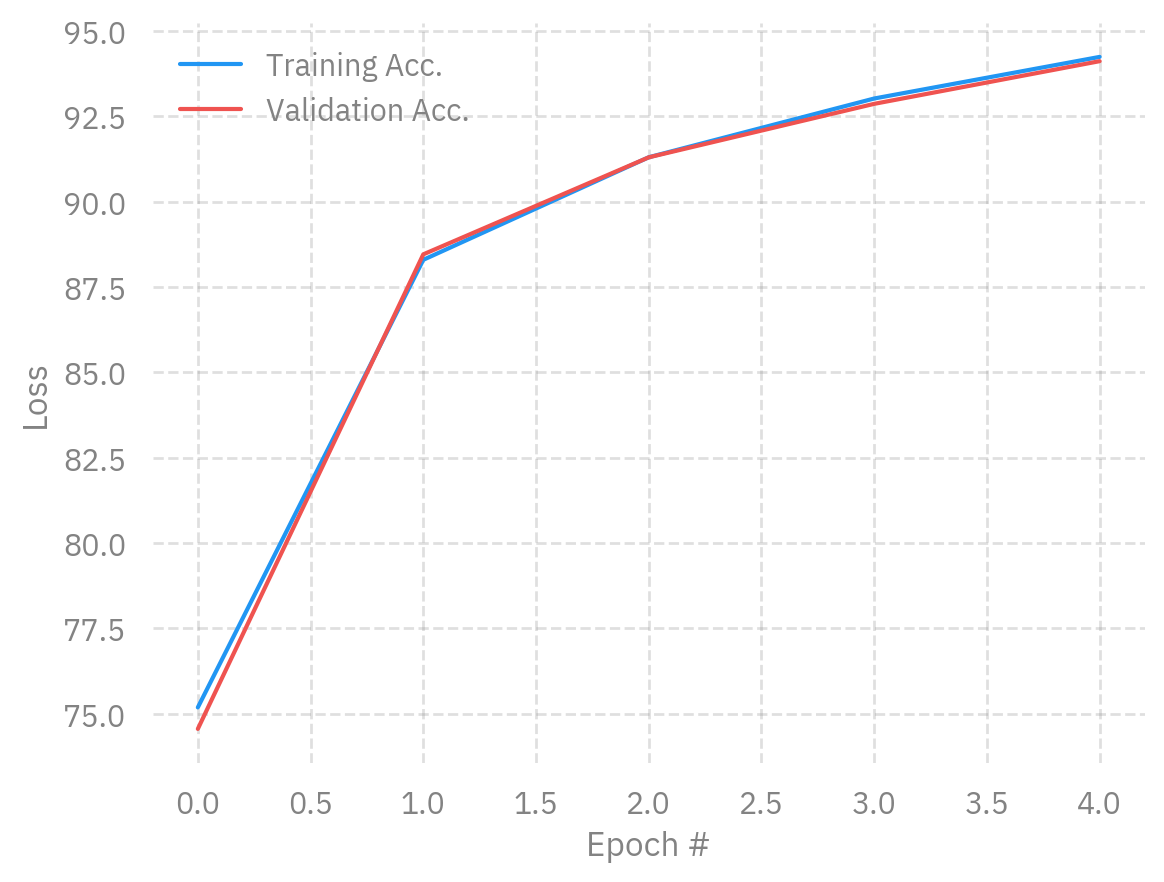

In [24]:
# pltsize=1
# plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.figure()
plt.plot(range(epochs), train_acc_all, label="Training Acc.")
plt.plot(range(epochs), val_acc_all, label="Validation Acc.")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

Showing max 10 first failures.
The predicted class is shown first and the correct class in parentheses.


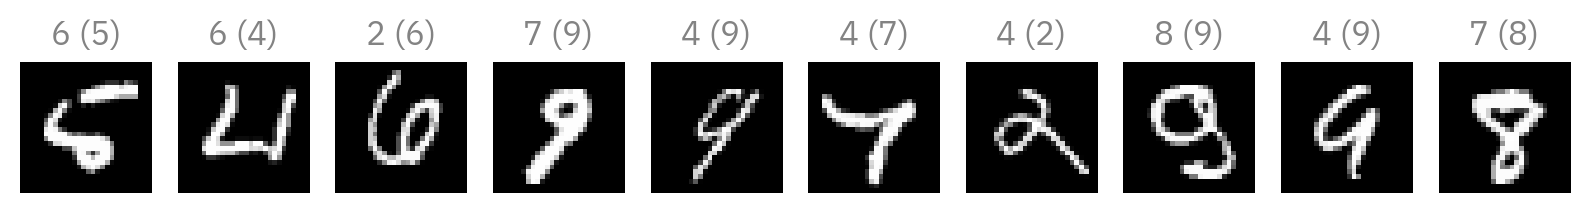

In [25]:
show_failures(nonlinear_model, test_dataloader)

## Recap

To train and validate a neural network model, you need:

- Data split into training/validation/test sets,
- A model with parameters to learn
- An appropriate loss function
- An optimizer (with tunable parameters such as learning rate, weight decay
  etc.) used to learn the parameters of the model.

## Homework

1. Compare the quality of your model when using different:
 - batch sizes
 - learning rates
 - activation functions

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model.

Note: training and validation data can be used to compare models, but test data
should be saved until the end as a final check of generalization.

## Homework solution

Make the following changes to the cells with the comment "#For HW"

In [26]:
#####################To modify the batch size##########################
batch_size = 32  # 64, 128, 256, 512

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
##############################################################################


##########################To change the learning rate##########################
optimizer = torch.optim.SGD(
    nonlinear_model.parameters(), lr=0.01
)  # modify the value of lr
##############################################################################


##########################To change activation##########################
###### Go to https://pytorch.org/docs/main/nn.html#non-linear-activations-weighted-sum-nonlinearity for more activations ######
class NonlinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28 * 28, 50),
            nn.Sigmoid(),  # nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),  # nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x


##############################################################################

Bonus question: A learning rate scheduler is an essential deep learning
technique used to dynamically adjust the learning rate during training.
This strategic can significantly impact the convergence speed and overall
performance of a neural network.
See below on how to incorporate it to your training.

In [27]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# Step learning rate scheduler: reduce by a factor of 0.1 every 2 epochs (only for illustrative purposes)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [28]:
%%time

epochs = 6
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
    #step the scheduler
    scheduler.step()

    # print the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {j+1}/{epochs}, Learning Rate: {current_lr}")

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 1/6, Learning Rate: 0.1
Epoch 0: training loss: 0.35453774413218103, accuracy: 89.84791666666668
val. loss: 0.3428567706346512, val. accuracy: 89.88333333333334

Epoch 2/6, Learning Rate: 0.01000000000000000289.88333333333334


1: training loss: 0.25014649585510296, accuracy: 92.55624999999999
Epoch 1: val. loss: 0.24179457187155884, val. accuracy: 92.60000000000001
3/6, Learning Rate: 0.010000000000000002accuracy: 92.60000000000001

Epoch 2: training loss: 0.23025922616074482, accuracy: 93.25416666666668
val. loss: 0.22265068178375563, val. accuracy: 93.18333333333332
Epoch 4/6, Learning Rate: 0.001000000000000000293.18333333333332

3: training loss: 0.223550607226789, accuracy: 93.43125332


Epoch 3: val. loss: 0.2162884232501189, val. accuracy: 93.30000000000001
5/6, Learning Rate: 0.0010000000000000002curacy: 93.30000000000001

Epoch 4: training loss: 0.22177774112671614, accuracy: 93.43125001


val. loss: 0.21469855186343192, val. accuracy: 93.45833333333333
Epoch 6/6, Learn